
# Test Performance of Models

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="6"
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l1
from keras.layers import Dense, Conv2D, Flatten, Dropout
import ptetaphi_nn
import tools
with open("filepath.txt", 'r') as f:
    filename = f.read().strip("\n")
    
s_table = tools.open_file(filename, sort_by="tag")

Using TensorFlow backend.


sorting data by tag


In [3]:
nt3 = s_table.nbtags==3  # 3 b tags
events = s_table[nt3]
#print(len(events))


cutoff = 10  # not many events have >10 jets
# "pad" = ensure all events have same length, cut off ends if needed
events = tools.pad(events, cutoff)

# then ensure require pt >= 40 and |eta| <= 2.5
#pt_filter = events.resolved_lv.pt < 40
#events.resolved_lv.pt[pt_filter] = 0
#events.resolved_lv.eta[pt_filter] = 0
#events.resolved_lv.phi[pt_filter] = 0

#eta_filter = (events.resolved_lv.eta >= -2.5) & (events.resolved_lv.eta >= 2.5)
#events.resolved_lv.pt[eta_filter] = 0
#events.resolved_lv.eta[eta_filter] = 0
#events.resolved_lv.phi[eta_filter] = 0
#print(events.resolved_lv.pt[0])
#print(events.tag[0])
print(len(events))

313660


In [44]:
import importlib
importlib.reload(ptetaphi_nn)
importlib.reload(tools)
nn = ptetaphi_nn.PtEtaPhiNN(events, load=("architecture_same_filters.json", "weights_same_filters.h5"), njets=10)

DATA FOR .csv file:
pt_mean,pt_var,eta_mean,eta_var,phi_mean,phi_var
257.9804267198343,29242.12072871294,-0.0015771052755922776,1.0690046414803567,0.0052632764246117614,3.2963776218776695
166.25408177401638,15319.781922258744,-0.00531389240260435,1.15474392679967,-0.0035193141043244037,3.2893450435412053
77.12934315496658,2008.8786125648442,-0.0011814623496528526,1.1893891231089375,-0.0016881561407949474,3.289966911439094
160.74513953094663,21269.163738329105,-0.0033976126778184116,2.4662127412184094,0.01089586196778229,3.272716803804568
59.26229923040079,4342.0030619553645,0.004766014780613432,2.733928758000363,-0.00035625073563435835,2.5893351086534113
24.63099704519991,1124.3797369145916,0.005469604018369251,2.0551683633763447,0.0020967183946320527,1.6394836895976266
10.07089756820485,379.7309156299025,0.0037123064057160158,1.1680920445270155,-0.00018795375215571828,0.8474314923035839
3.7850115506128943,132.0663603161607,0.0014991545654920782,0.5297806920564189,0.0024408840672462107

DATA FOR .csv file:
pt_mean,pt_var,eta_mean,eta_var,phi_mean,phi_var
65.84481048583984,0.0,0.14644603431224823,0.0,2.467890501022339,0.0
55.58110427856445,0.0,2.366142749786377,0.0,0.8504094481468201,0.0
52.65810775756836,0.0,0.7512547969818115,0.0,-2.326935052871704,0.0
56.41041946411133,0.0,1.6808229684829712,0.0,-1.0688464641571045,0.0
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
unscaled [65.84481    55.581104   52.658108   56.41042     0.          0.
  0.          0.          0.          0.          0.14644603  2.3661427
  0.7512548   1.680823    0.          0.          0.          0.
  0.          0.          2.4678905   0.85040945 -2.326935   -1.0688465
  0.          0.          0.          0.          0.          0.        ]
scaled [-5.76222003e-01 -5.15265882e-01 -7.34556973e-01 -5.16809106e-01
 -3.29360187e-01 -1.94782004e-01 -1.10037595e-01 -1.72298098e+00
 -4.68771964e-01 -3.8

 -2.017484   -2.5068715   0.          0.          0.          0.        ]
scaled [-5.76222003e-01 -5.15265882e-01 -7.34556973e-01 -5.16809106e-01
 -3.29360187e-01 -1.94782004e-01 -1.10037595e-01 -1.72298098e+00
 -4.68771964e-01 -3.81533056e-03 -3.43483035e-03 -2.05967342e-03
  1.09038805e-03 -2.64976034e-03  5.78943826e-02 -1.66172910e+00
 -1.63751980e-03  2.04173179e-04 -4.05969005e-03  1.08107855e-03
  2.81306473e-03]
model scores
0 0.9365
1 0.0075
2 0.0042
3 0.0033
4 0.0006
5 0.0001
6 0.0000
7 0.0478
Event 5
|Tag|Truth|Sel|pt
| 1 |  1  | 0 | 89.454
| 1 |  1  | 0 | 78.847
| 1 |  1  | 0 | 57.990
| 0 |  0  | 1 | 95.890
| 0 |  0  | 0 | 46.416
| 0 |  0  | 0 | 25.391

DATA FOR .csv file:
pt_mean,pt_var,eta_mean,eta_var,phi_mean,phi_var
352.0329284667969,0.0,0.9092711210250854,0.0,-2.7620303630828857,0.0
121.99662017822266,0.0,-0.8579763770103455,0.0,0.8956886529922485,0.0
109.19309997558594,0.0,0.29617026448249817,0.0,-2.51953125,0.0
333.84539794921875,0.0,1.4737536907196045,0.0,0.1932419

| 1 |  1  | 0 | 151.230
| 1 |  1  | 0 | 82.212
| 1 |  1  | 0 | 54.339
| 1 |  0  | 1 | 209.542
| 0 |  0  | 0 | 167.279
| 0 |  0  | 0 | 28.197
| 0 |  0  | 0 | 26.406



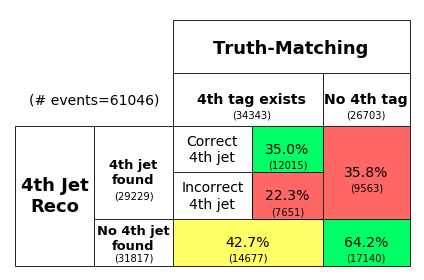

In [45]:
import awkward
import uproot_methods as urm
import importlib
importlib.reload(tools)

one_event = awkward.Table()

for index in range(12):
    lv = urm.TLorentzVectorArray.from_ptetaphie(events.resolved_lv.pt[index].reshape(1, -1),
                                                events.resolved_lv.eta[index].reshape(1, -1),
                                                events.resolved_lv.phi[index].reshape(1, -1),
                                                events.resolved_lv.E[index].reshape(1, -1))

    one_event.resolved_lv = lv
    one_event.truth = events.truth[index].reshape(1, -1)
    one_event.tag = events.tag[index].reshape(1, -1)

    selections = nn.evaluate(one_event, output=None)[0]
    print(f"Event {index}")
    print("|Tag|Truth|Sel|pt")
    for i in range(events.njets[index]):
        print(f"| {events.truth[index][i]} |  {events.tag[index][i]}  | {selections[i]} | {events.resolved_lv.pt[index][i]:.3f}")
    print()
selections = nn.evaluate()